# Quantitative Trading Strategy
#### By: Ruby Han

## Abstract
Forecasting market movement is a long-time attractive topic. This project aims to evaluate different algorithmic strategies on Apple, Microsoft, ExxonMobil, Chevron, Tesla using S&P 500 index as the benchmark over a one-year period (2021). An agent framework was built to trigger buy or sell orders with an initial capital of $10,000 based on selected strategy. Return on investment (ROI) was used as the performance metric. Base model outperformed other strategies with ROI of 31.5% but deep reinforcement learning model Evolution Strategy coming close in second place. Success of each strategy varied wildly with each stock for the time period. Machine learning models fared better than technical indicator models.

## Problem Objective 
- Create a quantitative trading strategy for any stocks
- No restriction on number of times entering or exiting the market, or long/short for period of strategy
- Benchmark with S&P 500 index
- Elucidate results and conclusion
- Provide future work and considerations given more time and resources

## Models Built

**Base Model:**

- Buy and Hold: Invest initial capital on first day and hold until last trading day

**Technical Indicators:**

- Bollinger Bands: Momentum model using moving standard deviations as bands

- MACD: Moving average convergence divergence index

**Machine Learning Models**

- Evolution Strategy: Deep reinforcement learning model

- LSTM: Long short-term memory model


## Result Summary

**Performance Metrix:**

$$\text{Return on Investment (ROI)}=\frac{\text{Current Value of Investment}-\text{Investment Cost}}{\text{Investment Cost}}$$

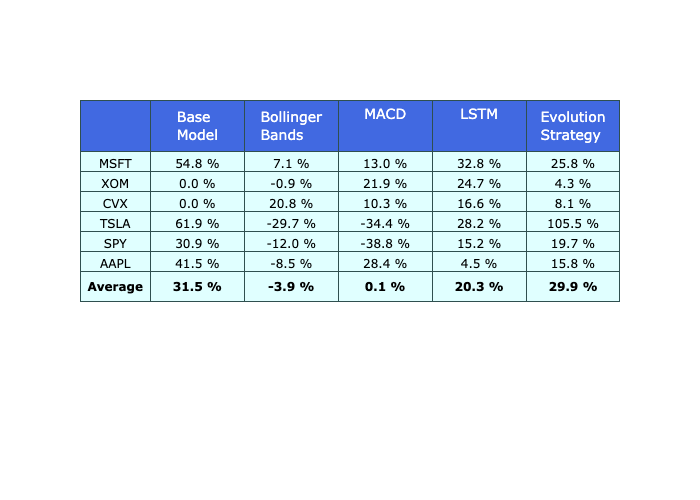

In [32]:
from IPython.display import Image, Markdown as md
Image('images/result_table.png')

## Navigation <a id = 0> </a>
- [Data Load](#1)
- [EDA](#2)
- [Feature Engineering](#3)
    - [MACD](#3.1)
    - [Bollinger Bands](#3.2)
    - [RSI](#3.3)
    - [Normal Distribution](#3.4)
- [Model](#4)
    - [Base Model](#4.0)
    - [Bollinger Bands](#4.1)
    - [MACD](#4.2)
    - [LSTM](#4.3)
    - [Evolution Strategy](#4.4)
- [Result](#5)
- [Conclusion](#6)
- [Future Work](#7)
- [References](#8)

In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
from itertools import compress

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

import yfinance as yf
import pandas_datareader as pdr

from feature_eng import MACD, bollinger_bands, RSI, momentum

import statsmodels.api as sm

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, max_error

from keras.layers import LSTM, Dense, Dropout
from keras.models import Sequential

import backtrader as bt

pd.set_option("display.max_rows", None, # display all rows
              "display.max_columns", None, # display all columns
              "display.max_colwidth", None, # expand column width
              "display.html.use_mathjax", False) # disable Latex style mathjax rendering

## Data Load <a id = 1> </a> 
[Back to Top](#0)

- ^GSPC : S&P 500 index data
- XOM : ExxonMobil
- CVX : Chevron
- AAPL : Apple
- TSLA : Tesla
- MSFT : Microsoft
- SPY : S&P 500 ETF

##### Terminology
- `Open` : Stock price at market open (USD)
- `High` : Highest price reached per day (USD)
- `Low` : Lowest price reached per day (USD)
- `Close` : Stock price at market close (USD)
- `Adj Close` : Adjusted stock price at market close (USD)
- `Volume` : Number of shares traded per day

In [3]:
# Obtain stock data from Yahoo Finance
start = '2021-01-04'
end = '2022-01-04'

tickers = [
    '^GSPC' # sp500 index
    ,'XOM' # exxon
    ,'CVX' # chevron
    ,'AAPL' # apple
    ,'TSLA' # tesla
    ,'MSFT' # microsoft
    ,'SPY' # sp500 ETF
          ]

for ticker in tickers:
    data = pdr.get_data_yahoo(ticker, '2000')
    data.to_csv(f'data/raw_stocks/{ticker}.csv')

# data = yf.download('AAPL', start=start, end=end)

## EDA <a id = 2> </a> 
[Back to Top](#0)

In [4]:
apple_raw_df = pd.read_csv('data/raw_stocks/AAPL.csv')
apple_raw_df.head()

Date      High       Low      Open     Close       Volume  Adj Close
0  2000-01-03  1.004464  0.907924  0.936384  0.999442  535796800.0   0.855797
1  2000-01-04  0.987723  0.903460  0.966518  0.915179  512377600.0   0.783644
2  2000-01-05  0.987165  0.919643  0.926339  0.928571  778321600.0   0.795111
3  2000-01-06  0.955357  0.848214  0.947545  0.848214  767972800.0   0.726304
4  2000-01-07  0.901786  0.852679  0.861607  0.888393  460734400.0   0.760708

In [5]:
apple_raw_df.shape

(5577, 7)

In [6]:
apple_raw_df.describe()

High          Low         Open        Close        Volume  \
count  5577.000000  5577.000000  5577.000000  5577.000000  5.577000e+03   
mean     25.623125    25.080007    25.351181    25.362543  4.266903e+08   
std      37.092281    36.266501    36.674211    36.698977  3.889364e+08   
min       0.235536     0.227143     0.231964     0.234286  3.934000e+07   
25%       1.576786     1.535714     1.560714     1.562143  1.555592e+08   
50%      11.973214    11.767857    11.872857    11.863929  3.106992e+08   
75%      30.962500    30.427500    30.690001    30.642500  5.665464e+08   
max     182.940002   179.119995   182.630005   182.009995  7.421641e+09   

         Adj Close  
count  5577.000000  
mean     24.255634  
std      36.590522  
min       0.200613  
25%       1.337623  
50%      10.158772  
75%      28.198088  
max     181.778397

In [7]:
apple_raw_df.dtypes

Date          object
High         float64
Low          float64
Open         float64
Close        float64
Volume       float64
Adj Close    float64
dtype: object

In [8]:
# Check for null values
# If exist, use last good value, mean, zero or drop observation
apple_raw_df.isna().sum()

Date         0
High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
dtype: int64

## Feature Engineering <a id = 3> </a> 
[Back to Top](#0)

- Indicators are tools that help traders/investors make buying/selling stocks decisions
- Technical indicators (features in our case):
    - Price
    - Volume
- The following features will be created:
    - Bollinger Bands
    - RSI
    - MACD
    - Moving Average
    - Momentum
    - Change
    - Volatility
    - Return
- Target variable: `Return`
- All other features will serve as predictors

In [9]:
!rm -rf data/raw_stocks/.ipynb_checkpoints
files = os.listdir('data/raw_stocks')
stocks = {}

for file in files:
    name = file.split('.')[0]
    stocks[name] = pd.read_csv(f'data/raw_stocks/{file}') 
    
    stocks[name]['Date'] = pd.to_datetime(stocks[name]['Date'])
    stocks[name].set_index('Date', inplace=True)
    
    # Bollinger Bands
    stocks[name]['upper_boll_band'], stocks[name]['lower_boll_band'] = bollinger_bands(stocks[name])
    
    # MACD
    stocks[name]['macd'], stocks[name]['signal'] = MACD(stocks[name])
    
    # RSI
    stocks[name]['rsi'] = RSI(stocks[name])
    
    # 7d MA
    stocks[name]['ma7'] = stocks[name].Close.rolling(window=7).mean()
    
    # 21d MA
    stocks[name]['ma21'] = stocks[name].Close.rolling(window=21).mean()
    
    # Momentum
    stocks[name]['momentum'] = momentum(stocks[name].Close, 3)
    
    # Difference between current and previous
    stocks[name]['change'] = (stocks[name].Close - stocks[name].Close.shift(1)).fillna(0)
    
    # Volatility
    stocks[name]['volatility'] = stocks[name].Close.ewm(21).std()
    
    # Return
    stocks[name]['return'] = round(stocks[name]['Close']/stocks[name]['Open'] - 1, 4)

    stocks[name].to_csv(f'data/stocks/{name}.csv')

In [10]:
files

['MSFT.csv',
 'XOM.csv',
 'CVX.csv',
 '^GSPC.csv',
 'TSLA.csv',
 'SPY.csv',
 'AAPL.csv']

In [11]:
apple_df = stocks['AAPL']

ticker_list = []

for i in files:
    ticker_name = i.split('.')[0]
    ticker_list.append(ticker_name)
ticker_list

['MSFT', 'XOM', 'CVX', '^GSPC', 'TSLA', 'SPY', 'AAPL']

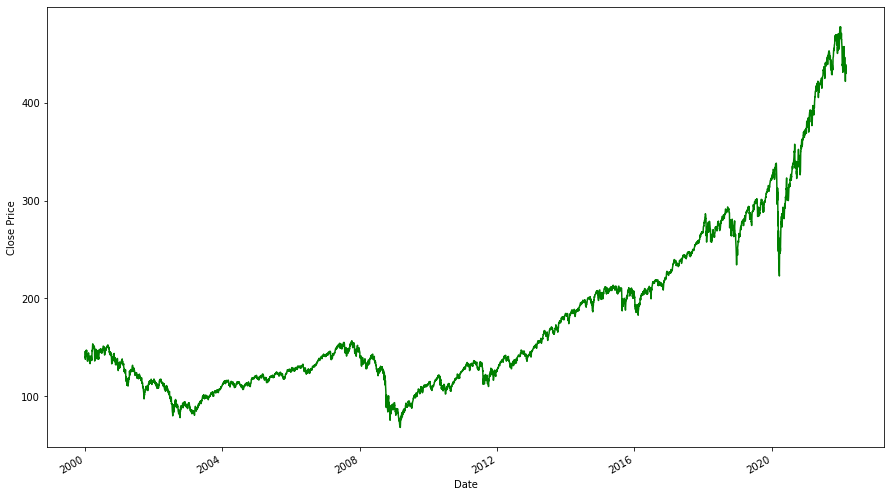

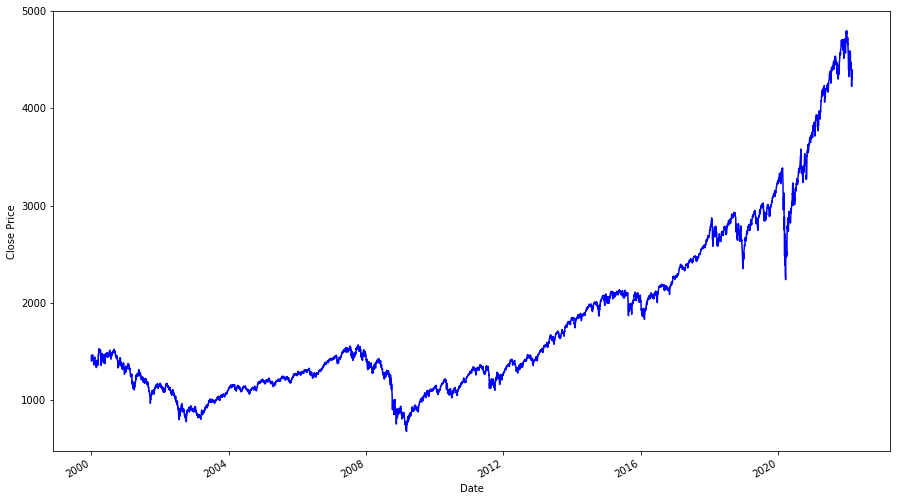

In [12]:
plt.figure(figsize = (15,9))
stocks['SPY'].Close.plot(c = 'g')
plt.ylabel('Close Price')
plt.show()

plt.figure(figsize = (15,9))
stocks['^GSPC'].Close.plot(c = 'b')
plt.ylabel('Close Price')
plt.show()

ticker_list.remove('^GSPC') # GSPC is an index and not tradeable

#### Correlation Plot
- `change` and `rsi` correlate with `return`

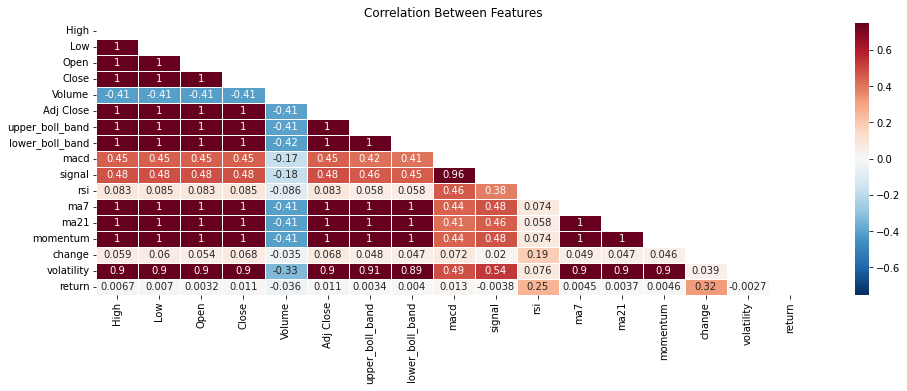

In [13]:
corr = apple_df.corr()

# Mask upper triangle
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Plot correlation matrix
plt.figure(figsize=(16, 5))
heatmap = sns.heatmap(corr, mask=mask, annot=True, linewidths=0.5, 
                      vmin=-0.75, vmax=0.75, cmap="RdBu_r")
heatmap.set_title('Correlation Between Features');

In [14]:
corr[['return']].sort_values(by='return', ascending=False)

return
return           1.000000
change           0.316702
rsi              0.253395
macd             0.013021
Adj Close        0.011076
Close            0.010647
Low              0.007033
High             0.006661
momentum         0.004569
ma7              0.004500
lower_boll_band  0.003998
ma21             0.003703
upper_boll_band  0.003437
Open             0.003203
volatility      -0.002748
signal          -0.003810
Volume          -0.036085

## $\underline{\text{Plots}}$

### MACD - Moving Average Convergence Divergence  <a id = 3.1> </a> 
[Back to Top](#0)
- Momentum indicator showing relationship between two moving averages
- Logic is that momentum has more impact on short moving average and we subtract short_ma from long_ma
- Difference is sometimes positive or negative, hence the name MACD (moving average converge/diverge oscillator)
    - Oscillator is the difference between the two MAs
    - When it is positive, we long and vice versa
- If short_ma > long_ma, then long and hold as stock is on the rise and will keep going up for some time
- If short_ma < long_ma, then clear positions

In [15]:
def macd(stock):
    plt.figure(figsize=(16,5))
    plt.plot(stock.macd, label='short_ma', color = '#b278ff')
    plt.plot(stock.signal, label='long_ma', color='#ffa74a')
    plt.axhline(0, color='#557692')
    plt.legend(frameon=True, loc=0, ncol=1, fontsize=10, borderpad=.6)
    plt.title('MACD', fontsize=15)
    plt.ylabel('Strength', fontsize=12)
    plt.show()
    
    plt.figure(figsize=(16,5))
    (stock.macd - stock.signal).plot(kind='bar',color='r')
    plt.grid(True)
    plt.xticks([])
    plt.xlabel('')
    plt.title('MACD Oscillator', fontsize=15)
    plt.show()

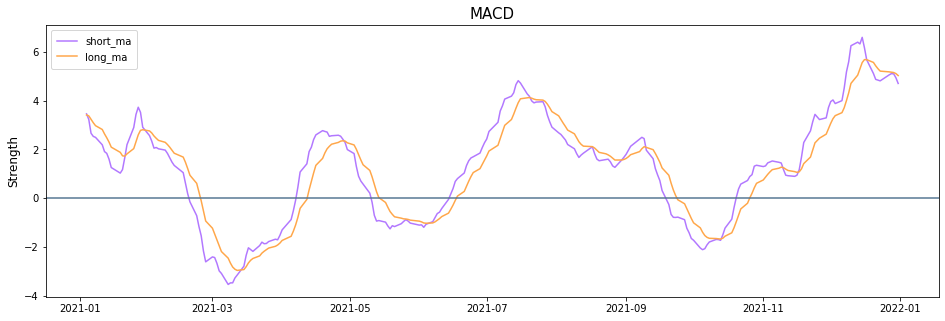

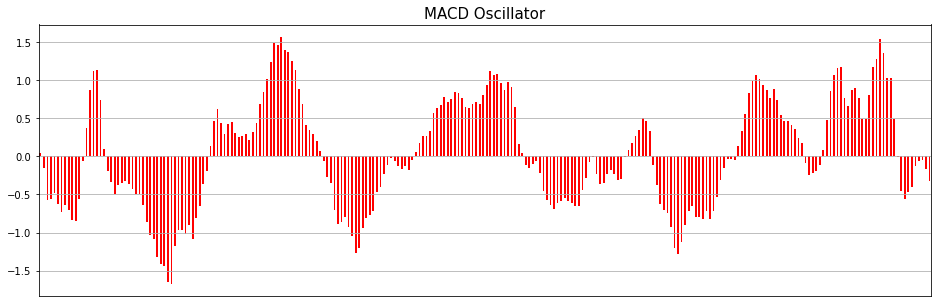

In [16]:
macd(apple_df.loc['2021':'2021'])

### Bollinger Bands  <a id = 3.2> </a> 
[Back to Top](#0)
- Price almost never leaves Bollinger Bands space
    - Price is fluctuating between three standard deviations
- Good indicator as buying/selling signal

In [17]:
def bollinger_bands_plot(stock, std=2):    
    plt.figure(figsize=(16,5))
    plt.style.use('seaborn-whitegrid')
    plt.plot(stock.index, stock.Close, color='#3388cf', label='Price')
    plt.plot(stock.index, stock.ma21, color='#ad6eff', label='Moving Average (21 days)')
    plt.plot(stock.index, stock.ma7, color='#ff6e9d', label='Moving Average (7 days)')
    plt.plot(stock.index, stock.upper_boll_band, color='#ffbd74', alpha=0.3)
    plt.plot(stock.index, stock.lower_boll_band, color='#ffa33f', alpha=0.3)
    plt.fill_between(stock.index, stock.upper_boll_band, stock.lower_boll_band, color='#ffa33f', alpha=0.1, label=f'Bollinger Band ({std} STD)')
    plt.legend(frameon=True, loc=0, ncol=1, fontsize=10, borderpad=.6)
    plt.title('Bollinger Bands', fontsize=15)
    plt.ylabel('Price', fontsize=12)
    plt.xlim([stock.index.min(), stock.index.max()])
    plt.show()

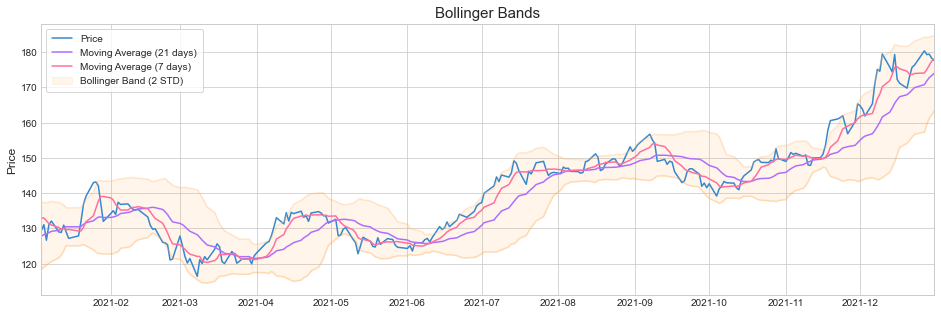

In [18]:
bollinger_bands_plot(apple_df.loc['2021':'2021'])

### RSI - Relative Strength Index <a id = 3.3> </a> 
[Back to Top](#0)
- A momentum indicator that can tell if stock is overbought or oversold
- Ranges from 0 to 100
- When index approaches 30, signal to buy
- When index approaches 70, signal to sell

In [19]:
def rsi(stock):
    plt.figure(figsize=(16,5)) 
    plt.plot(stock.index, stock.rsi, color='#ad6eff')
    plt.xlim([stock.index.min(), stock.index.max()])
    plt.axhline(30, color='#f9989c')
    plt.axhline(70, color='#60e8ad')
    plt.title('RSI', fontsize=15)
    plt.ylabel('%', fontsize=12)
    plt.ylim([0, 100])
    plt.show()

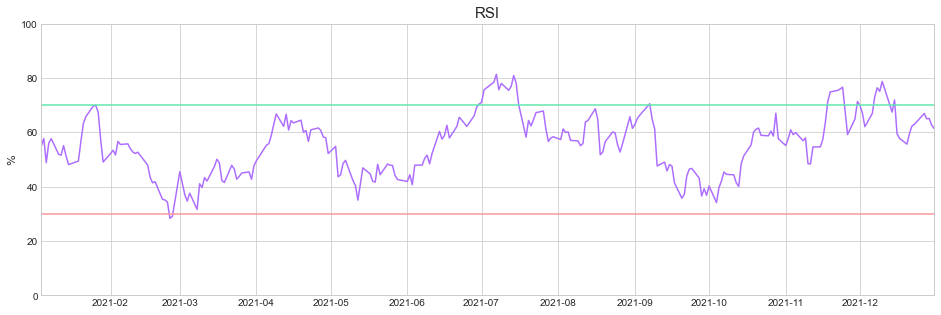

In [20]:
rsi(apple_df.loc['2021':'2021'])

### Normal Distribution <a id = 3.4> </a> 
[Back to Top](#0)
- ML algorithms require normal distribution of data to work well
- Target var `return` mostly normal

In [21]:
apple_df.head()

High       Low      Open     Close       Volume  Adj Close  \
Date                                                                         
2000-01-03  1.004464  0.907924  0.936384  0.999442  535796800.0   0.855797   
2000-01-04  0.987723  0.903460  0.966518  0.915179  512377600.0   0.783644   
2000-01-05  0.987165  0.919643  0.926339  0.928571  778321600.0   0.795111   
2000-01-06  0.955357  0.848214  0.947545  0.848214  767972800.0   0.726304   
2000-01-07  0.901786  0.852679  0.861607  0.888393  460734400.0   0.760708   

            upper_boll_band  lower_boll_band      macd    signal  rsi  ma7  \
Date                                                                         
2000-01-03              NaN              NaN  0.000000  0.000000  NaN  NaN   
2000-01-04              NaN              NaN -0.006722 -0.001344  NaN  NaN   
2000-01-05              NaN              NaN -0.010843 -0.003244  NaN  NaN   
2000-01-06              NaN              NaN -0.020359 -0.006667  NaN  NaN   
2000-01-07              NaN              NaN -0.024377 -0.010209  NaN  NaN   

            ma21  momentum    change  volatility  return  
Date                                                      
2000-01-03   NaN       NaN  0.000000         NaN  0.0673  
2000-01-04   NaN       NaN -0.084263    0.059583 -0.0531  
2000-01-05   NaN       NaN  0.013392    0.044683  0.0024  
2000-01-06   NaN -2.000558 -0.080357    0.061924 -0.1048  
2000-01-07   NaN -2.084821  0.040179    0.055008  0.0311

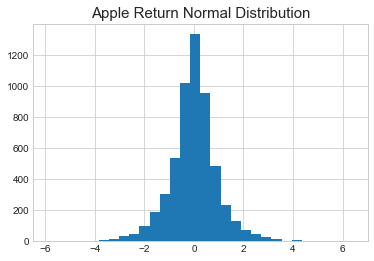

In [22]:
z = lambda x: (x - x.mean()) / x.std()

plt.hist(z(apple_df['return']), bins=30)
plt.title('Apple Return Normal Distribution', fontsize=15)
plt.show()

<Figure size 1152x360 with 0 Axes>

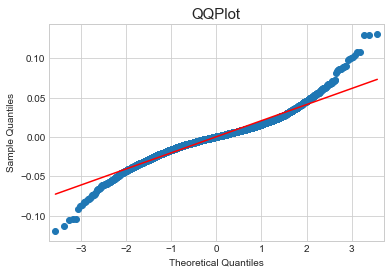

In [23]:
plt.figure(figsize=(16,5))
sm.qqplot(apple_df['return'], line='s', scale=1)
plt.title('QQPlot', fontsize=15);

## Model <a id = 4> </a> 
[Back to Top](#0)
- **Base Model:** Buy and Hold
- **Technical Indicator:** Bollinger Bands and MACD
- **NN Model:** LSTM
- **Deep Reinforcement Learning (DRL):** Evolution Strategy

### Base Model <a id = 4.0> </a> 

In [24]:
initial_cap = 10000

class BuyAndHold_Buy(bt.Strategy):
    def start(self):
        # set the starting cash
        self.val_start = self.broker.get_cash() 
    def nextstart(self):
        # Buy stocks with all the available cash
        size = int(self.val_start / self.data)
        self.buy(size=size)
    def stop(self):
        # calculate the actual returns
        self.roi = (self.broker.get_value() / self.val_start) - 1.0
        globals()[f'base_ROI_{ticker_name}'] = round(self.roi*100,2)
        print("ROI: %.2f, Cash: %.2f" % (100.0 * self.roi, self.broker.get_value()))
        
for ticker_name in ticker_list:
    print(f'\n{ticker_name}')
    data = bt.feeds.PandasData(dataname=yf.download(ticker_name, start=start, end=end, auto_adjust=True))
    cerebro = bt.Cerebro()
    cerebro.adddata(data)
    cerebro.addstrategy(BuyAndHold_Buy, "HODL")
    cerebro.broker.setcash(initial_cap)
    cerebro.run()


MSFT
[*********************100%***********************]  1 of 1 completed
ROI: 54.76, Cash: 15476.29

XOM
[*********************100%***********************]  1 of 1 completed
ROI: 0.00, Cash: 10000.00

CVX
[*********************100%***********************]  1 of 1 completed
ROI: 0.00, Cash: 10000.00

TSLA
[*********************100%***********************]  1 of 1 completed
ROI: 61.90, Cash: 16189.56

SPY
[*********************100%***********************]  1 of 1 completed
ROI: 30.90, Cash: 13090.21

AAPL
[*********************100%***********************]  1 of 1 completed
ROI: 41.46, Cash: 14145.77


### Technical Indicator - Bollinger Bands <a id = 4.1> </a> 
[Back to Top](#0)

In [25]:
def trading_history(stock, net, std=2):    
    
    # Bollinger band plot with EMA and original historical data
    plt.figure(figsize=(16,5))
    plt.style.use('seaborn-whitegrid')
    plt.plot(stock.index, stock.Close, color='#3388cf', label='Price')
    plt.plot(stock.index, stock.ma21, color='#ad6eff', label='Moving Average (21 days)')
    plt.plot(stock.index, stock.upper_boll_band, color='#ffbd74', alpha=0.3)
    plt.plot(stock.index, stock.lower_boll_band, color='#ffa33f', alpha=0.3)
    plt.fill_between(stock.index, stock.upper_boll_band, stock.lower_boll_band, color='#ffa33f', alpha=0.1, label='Bollinger Band ({} STD)'.format(std))
    
    for i in net:
        if i[2] == 1: color = '#ff005e'
        else: color = '#4bd81d'
        plt.plot_date(i[0], i[1], color=color)
        
    plt.plot_date([],[],label='Buy', c='#ff005e')
    plt.plot_date([],[],label='Sell', c='#4bd81d')
        
    plt.legend(frameon=True, loc=0, ncol=1, fontsize=10, borderpad=.6)
    plt.title('Trading History', fontsize=15)
    plt.ylabel('Price', fontsize=12)
    plt.xlim([stock.index.min(), stock.index.max()])
    plt.show()


MSFT
Number of Trades: 24
Time Frame: 351 days
Initial Capital: $10000
Percentage Gain: $710.08 | 7.1%


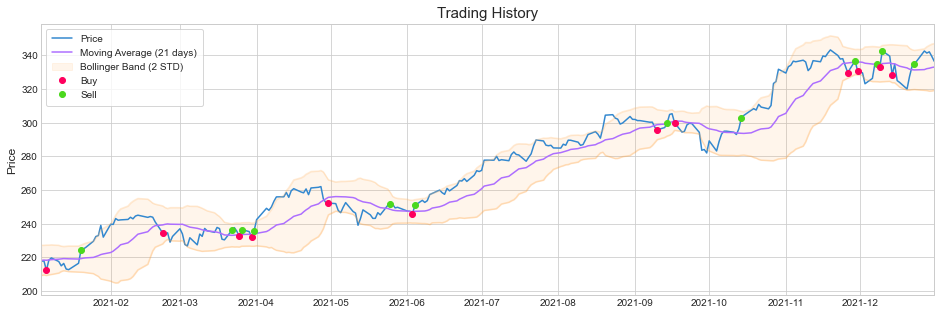


XOM
Number of Trades: 17
Time Frame: 261 days
Initial Capital: $10000
Percentage Gain: $-91.23 | -0.91%


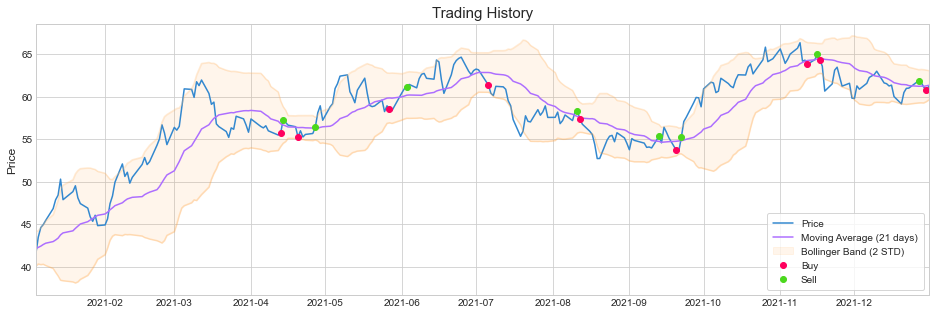


CVX
Number of Trades: 24
Time Frame: 327 days
Initial Capital: $10000
Percentage Gain: $2077.52 | 20.78%


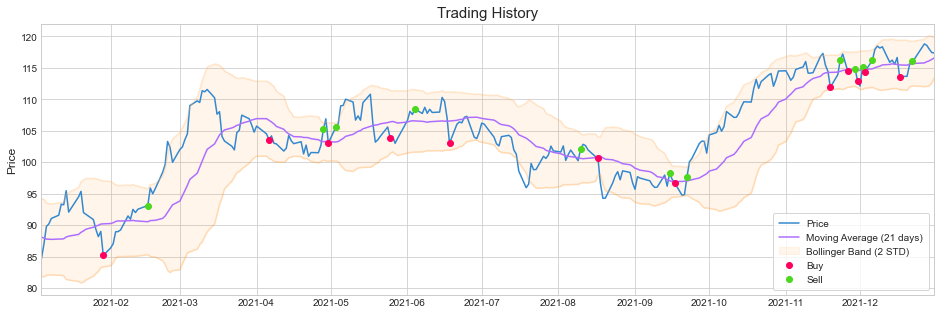


TSLA
Number of Trades: 7
Time Frame: 302 days
Initial Capital: $10000
Percentage Gain: $-2973.40 | -29.73%


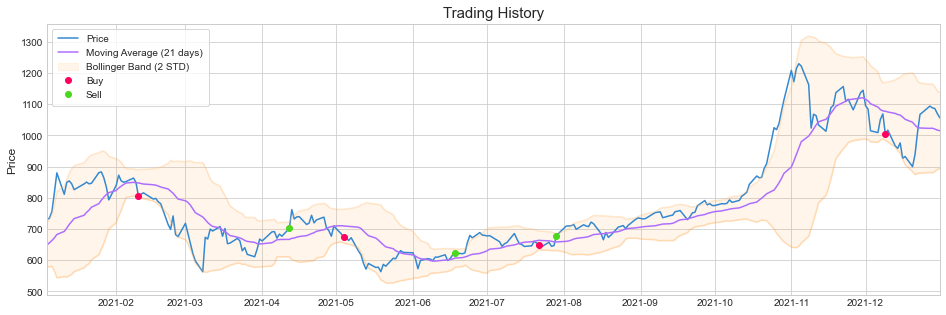


SPY
Number of Trades: 30
Time Frame: 351 days
Initial Capital: $10000
Percentage Gain: $-1201.86 | -12.02%


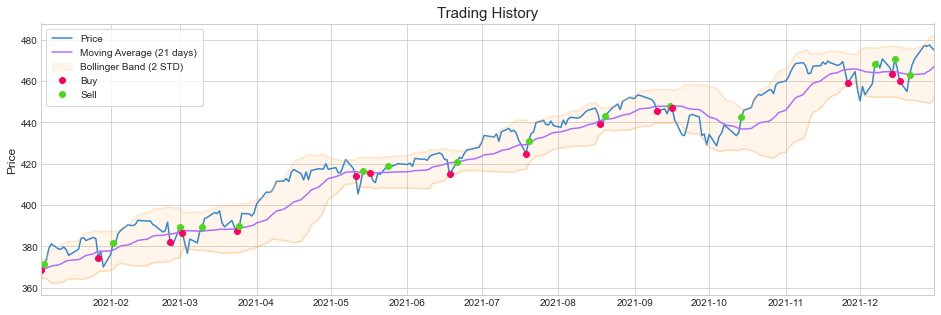


AAPL
Number of Trades: 14
Time Frame: 301 days
Initial Capital: $10000
Percentage Gain: $-850.61 | -8.51%


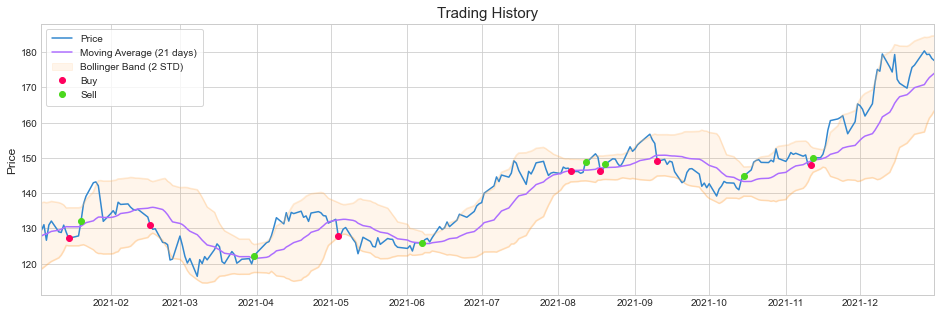

In [26]:
def bb_trading(stock, budget=10000, u=0.03, l=0.03, show_graph=True, show_return=True):
    
    money = budget
    stock = stock.reset_index()
    net = []
    for i in range(len(stock)):
        today = stock.iloc[i]
        
        # Buy
        if (today.Close < today.ma21) and (abs(1 - today.Close / today.lower_boll_band) < u):
            if money > 0:
                stock_amt = int(money / today.Close)
                money = 0
                net.append([today.Date, today.Close, 1, stock_amt * today.Close])

        # Sell        
        if (today.Close > today.ma21) and (abs(1 - today.upper_boll_band / today.Close) < l):
            if money == 0:
                money = stock_amt * today.Close
                stock_amt = 0
                net.append([today.Date, today.Close, 0, money])
        
    profit = net[-1][3] - budget
    
    if show_return == True:
        print('Number of Trades: {}'.format(len(net)))
        print('Time Frame: {} days'.format((net[-1][0] - net[0][0]).days))
        print(f'Initial Capital: ${budget}')
        print('Percentage Gain: ${:.2f} | {}%'.format(profit, round(profit/budget*100, 2)))

    if show_graph == True:
        trading_history(stock.set_index('Date'), net)

    return profit, net, budget

for ticker_name in ticker_list:
    print(f'\n{ticker_name}')
    A = bb_trading(stocks[ticker_name].loc['2021':'2021'], u=0.03, l=0.03);
    globals()[f'bb_ROI_{ticker_name}'] = round(A[0]/A[2]*100, 2)

### Technical Indicator - MACD <a id = 4.2> </a> 
[Back to Top](#0)


MSFT
Number of Trades: 21
Time Frame: 340 days
Initial Capital: $10000
Profit: $1300.85 | 13.01%


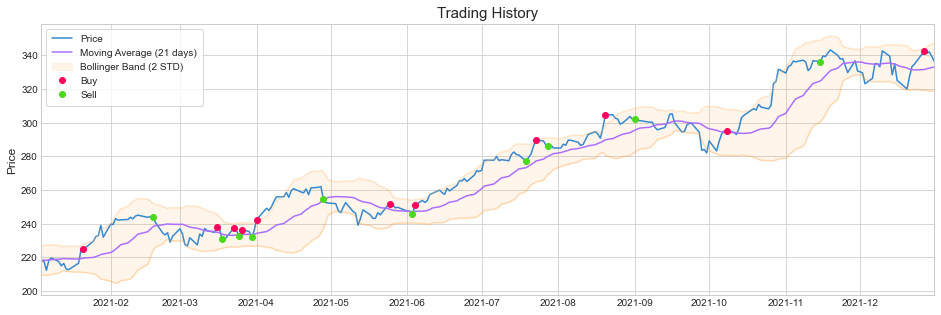


XOM
Number of Trades: 17
Time Frame: 354 days
Initial Capital: $10000
Profit: $2192.33 | 21.92%


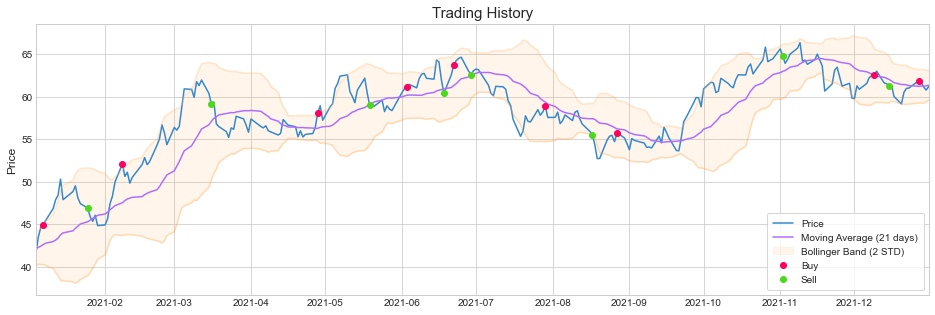


CVX
Number of Trades: 19
Time Frame: 355 days
Initial Capital: $10000
Profit: $1026.08 | 10.26%


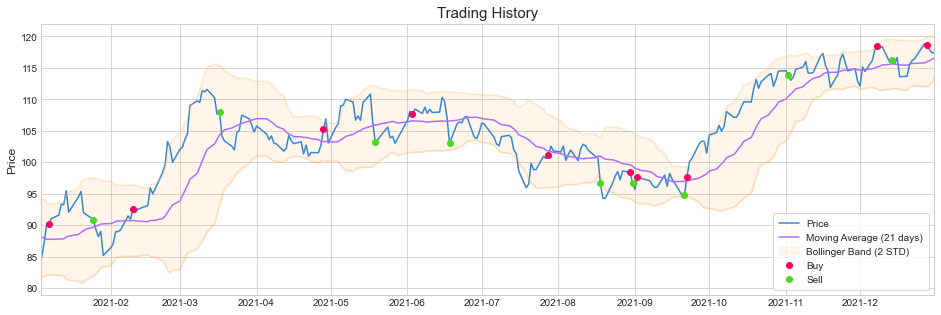


TSLA
Number of Trades: 19
Time Frame: 290 days
Initial Capital: $10000
Profit: $-3436.36 | -34.36%


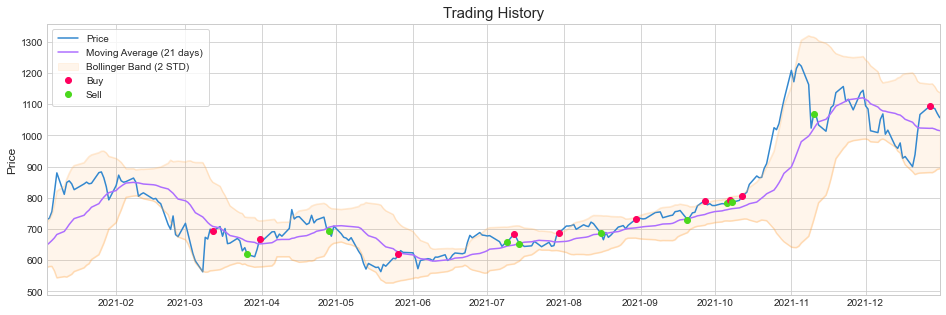


SPY
Number of Trades: 29
Time Frame: 350 days
Initial Capital: $10000
Profit: $-3882.20 | -38.82%


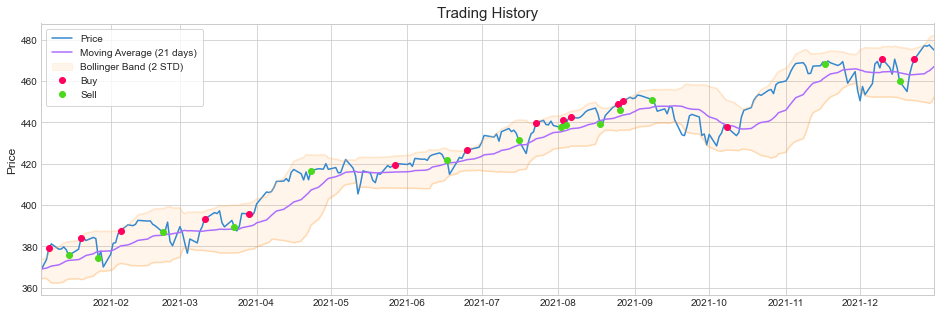


AAPL
Number of Trades: 12
Time Frame: 329 days
Initial Capital: $10000
Profit: $2835.50 | 28.35%


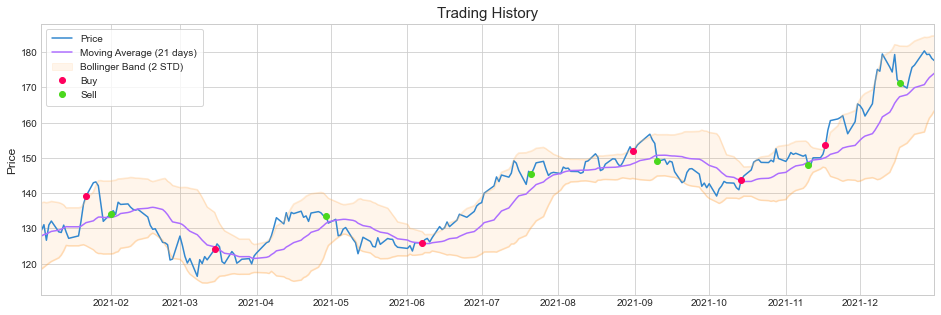

In [27]:
def macd_trading(stock, budget=10000, show_graph=True, show_return=True):
    
    state_check = lambda x, y: 1 if x > y else 0
    stock = stock.reset_index()    
    money = budget
    prev_state = state_check(stock.loc[0].macd, stock.loc[0].signal)
    stock_amt = 0
    net = []

    for i in range(1, len(stock)):

        today = stock.iloc[i]
        state = state_check(today.macd, today.signal)

        if state != prev_state:

            # BUY
            if (today.macd > today.signal) and (money != 0):
                stock_amt = int(money / today.Close)
                money = 0
                net.append([today.Date, today.Close, 1, stock_amt * today.Close])

            # SELL
            if (today.macd < today.signal) and (stock_amt != 0):
                money = stock_amt * today.Close
                stock_amt = 0
                net.append([today.Date, today.Close, 0, money])

        prev_state = state
    
    profit = net[-1][3] - budget
    
    if show_return == True:
        print('Number of Trades: {}'.format(len(net)))
        print('Time Frame: {} days'.format((net[-1][0] - net[0][0]).days))
        print(f'Initial Capital: ${budget}')
        print('Profit: ${:.2f} | {}%'.format(profit, round(profit/budget*100, 2)))

    if show_graph == True:
        trading_history(stock.set_index('Date'), net)

    return profit, net, budget


for ticker_name in ticker_list:
    print(f'\n{ticker_name}')
    A = macd_trading(stocks[ticker_name].loc['2021':'2021']);
    globals()[f'macd_ROI_{ticker_name}'] = round(A[0]/A[2]*100, 2)

### LSTM <a id = 4.3> </a> 
[Back to Top](#0)


MSFT
[*********************100%***********************]  1 of 1 completed
Epoch 1/5
21/21 [==============================] - 6s 72ms/step - loss: 0.0422
Epoch 2/5
21/21 [==============================] - 1s 68ms/step - loss: 0.0096
Epoch 3/5
21/21 [==============================] - 1s 69ms/step - loss: 0.0068
Epoch 4/5
21/21 [==============================] - 1s 69ms/step - loss: 0.0052
Epoch 5/5
21/21 [==============================] - 1s 68ms/step - loss: 0.0044


RMSE: 13.411114267011284


Initial Capital: $10000
Final Balance: $13283.58
Percentage Gain: 32.84%


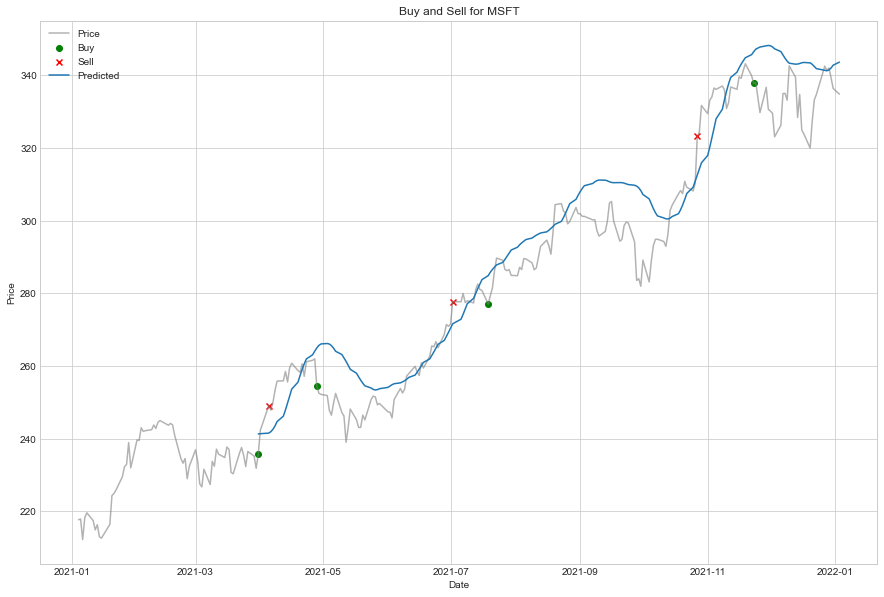


XOM
[*********************100%***********************]  1 of 1 completed
Epoch 1/5
21/21 [==============================] - 6s 69ms/step - loss: 0.0754
Epoch 2/5
21/21 [==============================] - 1s 68ms/step - loss: 0.0133
Epoch 3/5
21/21 [==============================] - 1s 67ms/step - loss: 0.0120
Epoch 4/5
21/21 [==============================] - 1s 69ms/step - loss: 0.0087
Epoch 5/5
21/21 [==============================] - 1s 69ms/step - loss: 0.0079


RMSE: 1.423106290887615


Initial Capital: $10000
Final Balance: $12471.32
Percentage Gain: 24.71%


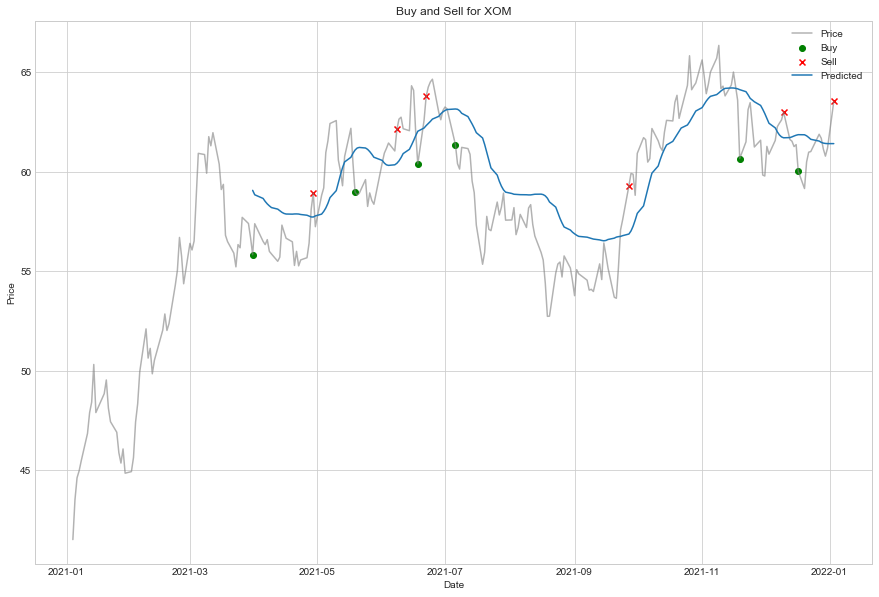


CVX
[*********************100%***********************]  1 of 1 completed
Epoch 1/5
21/21 [==============================] - 6s 71ms/step - loss: 0.0562
Epoch 2/5
21/21 [==============================] - 1s 70ms/step - loss: 0.0159
Epoch 3/5
21/21 [==============================] - 1s 69ms/step - loss: 0.0111
Epoch 4/5
21/21 [==============================] - 1s 68ms/step - loss: 0.0096
Epoch 5/5
21/21 [==============================] - 1s 69ms/step - loss: 0.0075


RMSE: 2.285773926511062


Initial Capital: $10000
Final Balance: $11654.57
Percentage Gain: 16.55%


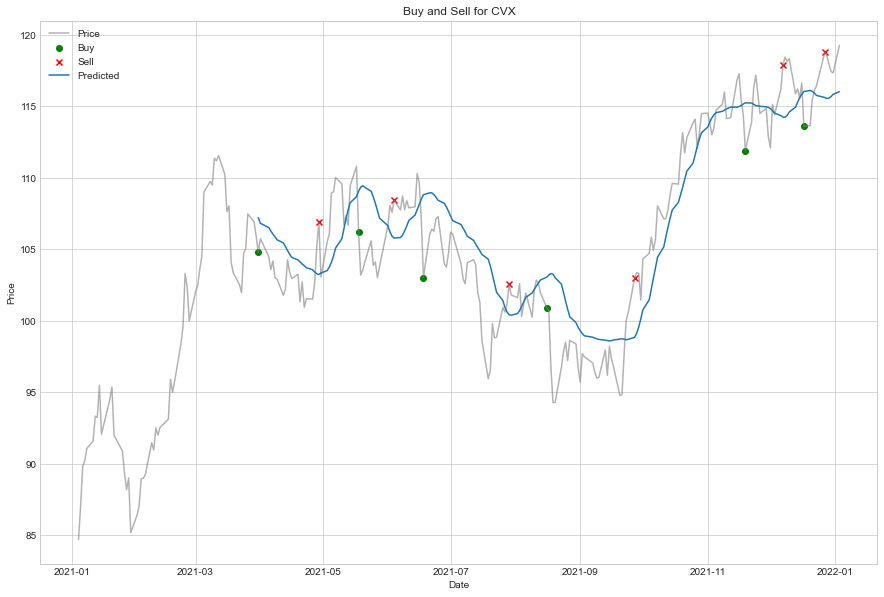


TSLA
[*********************100%***********************]  1 of 1 completed
Epoch 1/5
21/21 [==============================] - 6s 69ms/step - loss: 0.0277
Epoch 2/5
21/21 [==============================] - 1s 69ms/step - loss: 0.0137
Epoch 3/5
21/21 [==============================] - 1s 70ms/step - loss: 0.0112
Epoch 4/5
21/21 [==============================] - 1s 68ms/step - loss: 0.0108
Epoch 5/5
21/21 [==============================] - 1s 69ms/step - loss: 0.0083


RMSE: 86.58193372958367


Initial Capital: $10000
Final Balance: $12820.03
Percentage Gain: 28.20%


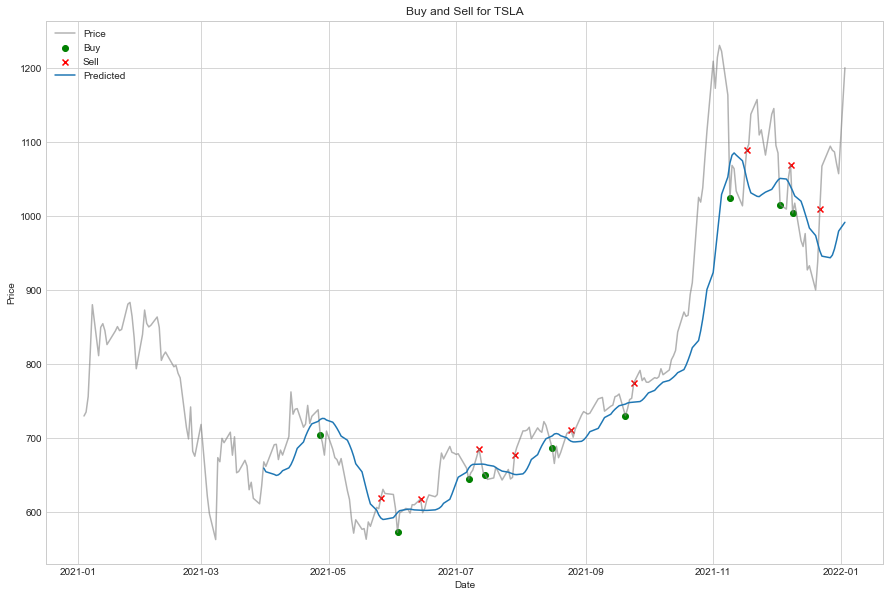


SPY
[*********************100%***********************]  1 of 1 completed
Epoch 1/5
21/21 [==============================] - 7s 91ms/step - loss: 0.0357
Epoch 2/5
21/21 [==============================] - 2s 96ms/step - loss: 0.0054
Epoch 3/5
21/21 [==============================] - 2s 100ms/step - loss: 0.0053
Epoch 4/5
21/21 [==============================] - 2s 95ms/step - loss: 0.0051
Epoch 5/5
21/21 [==============================] - 2s 92ms/step - loss: 0.0043


RMSE: 9.088842983633743


Initial Capital: $10000
Final Balance: $11524.00
Percentage Gain: 15.24%


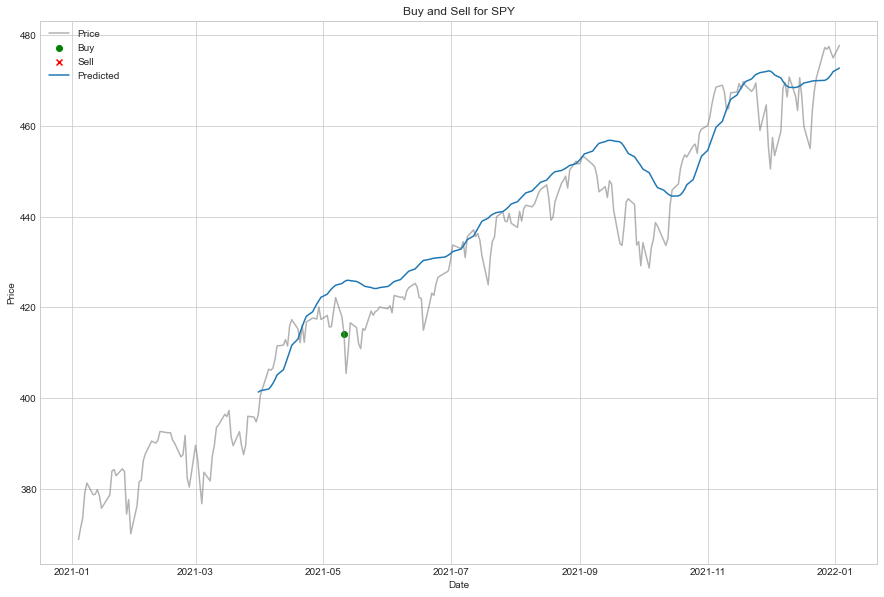


AAPL
[*********************100%***********************]  1 of 1 completed
Epoch 1/5
21/21 [==============================] - 6s 68ms/step - loss: 0.0206
Epoch 2/5
21/21 [==============================] - 1s 68ms/step - loss: 0.0065
Epoch 3/5
21/21 [==============================] - 1s 68ms/step - loss: 0.0045
Epoch 4/5
21/21 [==============================] - 1s 70ms/step - loss: 0.0044
Epoch 5/5
21/21 [==============================] - 1s 68ms/step - loss: 0.0039


RMSE: 7.616317748069043


Initial Capital: $10000
Final Balance: $10455.09
Percentage Gain: 4.55%


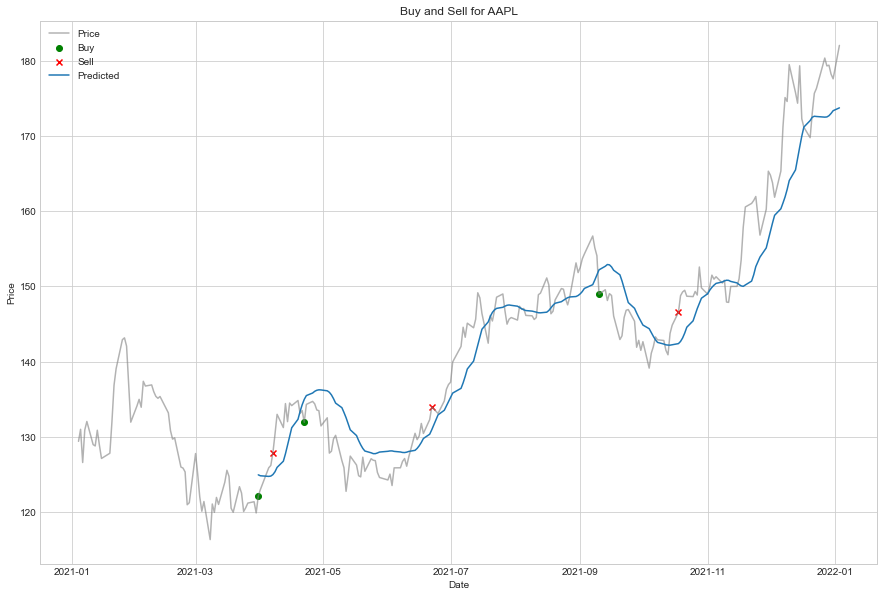

In [28]:
for ticker_name in ticker_list:
    print(f'\n{ticker_name}')
    %run modelling/agent_lstm.ipynb
    globals()[f'lstm_ROI_{ticker_name}'] = round(100*(agent.total_balance()-invest)/invest, 2)

### DRL - Evolution Strategy <a id = 4.4> </a> 
[Back to Top](#0)


MSFT
[*********************100%***********************]  1 of 1 completed
iter 10. reward: 2.773999
iter 20. reward: 6.337499
iter 30. reward: 10.256100
iter 40. reward: 15.515800
iter 50. reward: 17.737300
iter 60. reward: 15.121000
iter 70. reward: 18.130200
iter 80. reward: 16.987400
iter 90. reward: 20.583500
iter 100. reward: 15.914700
iter 110. reward: 18.016100
iter 120. reward: 20.181900
iter 130. reward: 22.101201
iter 140. reward: 18.363601
iter 150. reward: 10.235601
iter 160. reward: 20.674901
iter 170. reward: 20.371601
iter 180. reward: 19.187301
iter 190. reward: 19.090901
iter 200. reward: 20.843401
iter 210. reward: 21.173500
iter 220. reward: 19.316100
iter 230. reward: 17.462300
iter 240. reward: 17.996200
iter 250. reward: 19.242800
iter 260. reward: 19.091001
iter 270. reward: 21.383000
iter 280. reward: 22.509200
iter 290. reward: 20.620200
iter 300. reward: 20.929200
iter 310. reward: 22.816501
iter 320. reward: 22.113600
iter 330. reward: 17.387401
iter 340. re

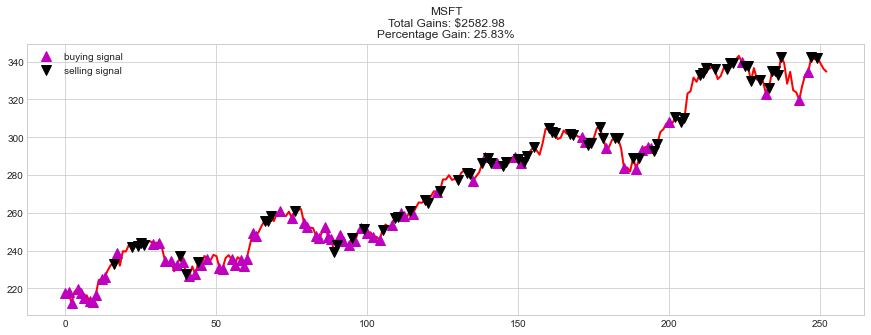


XOM
[*********************100%***********************]  1 of 1 completed
iter 10. reward: 0.676400
iter 20. reward: 1.362500
iter 30. reward: 1.509200
iter 40. reward: 1.531000
iter 50. reward: 2.290200
iter 60. reward: 1.649900
iter 70. reward: 2.321400
iter 80. reward: 3.032900
iter 90. reward: 2.951200
iter 100. reward: 3.508100
iter 110. reward: 3.576600
iter 120. reward: 3.229900
iter 130. reward: 3.024100
iter 140. reward: 3.291500
iter 150. reward: 3.505900
iter 160. reward: 2.969600
iter 170. reward: 3.685100
iter 180. reward: 4.064200
iter 190. reward: 4.001400
iter 200. reward: 4.107100
iter 210. reward: 3.746200
iter 220. reward: 4.009700
iter 230. reward: 4.203800
iter 240. reward: 4.063400
iter 250. reward: 3.821400
iter 260. reward: 3.843700
iter 270. reward: 3.948300
iter 280. reward: 3.843900
iter 290. reward: 3.538600
iter 300. reward: 3.675200
iter 310. reward: 3.806800
iter 320. reward: 3.847700
iter 330. reward: 4.099900
iter 340. reward: 3.867600
iter 350. reward:

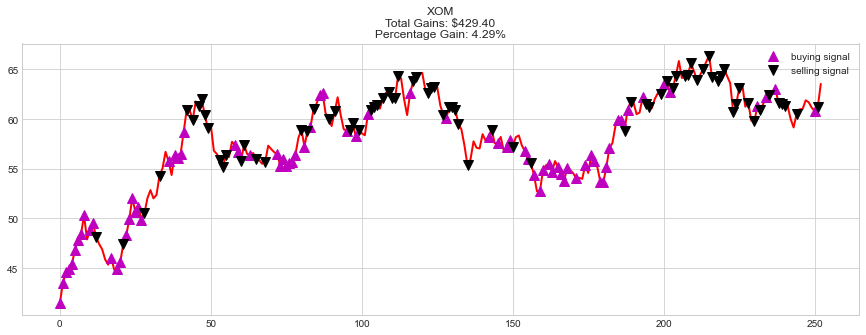


CVX
[*********************100%***********************]  1 of 1 completed
iter 10. reward: -0.115800
iter 20. reward: 0.035200
iter 30. reward: 1.320200
iter 40. reward: 2.624800
iter 50. reward: 3.862900
iter 60. reward: 4.562000
iter 70. reward: 3.872899
iter 80. reward: 3.829700
iter 90. reward: 4.222500
iter 100. reward: 4.463600
iter 110. reward: 4.572800
iter 120. reward: 5.043900
iter 130. reward: 5.193600
iter 140. reward: 6.098400
iter 150. reward: 5.927100
iter 160. reward: 6.076800
iter 170. reward: 6.917200
iter 180. reward: 5.556200
iter 190. reward: 6.418700
iter 200. reward: 6.906700
iter 210. reward: 4.577600
iter 220. reward: 2.153400
iter 230. reward: 6.841900
iter 240. reward: 7.095100
iter 250. reward: 6.226300
iter 260. reward: 6.196700
iter 270. reward: 7.301200
iter 280. reward: 6.797800
iter 290. reward: 7.304400
iter 300. reward: 6.767300
iter 310. reward: 7.498700
iter 320. reward: 8.143000
iter 330. reward: 7.372100
iter 340. reward: 7.653900
iter 350. reward

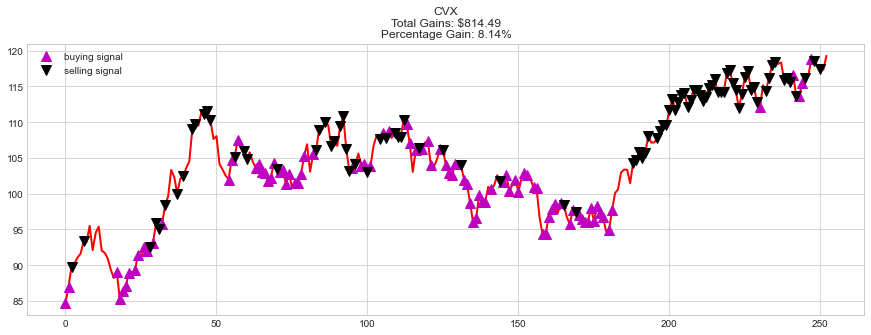


TSLA
[*********************100%***********************]  1 of 1 completed
iter 10. reward: 31.476798
iter 20. reward: 29.655597
iter 30. reward: 48.100895
iter 40. reward: 58.577796
iter 50. reward: 61.516194
iter 60. reward: 66.038696
iter 70. reward: 63.139596
iter 80. reward: 65.851793
iter 90. reward: 75.532894
iter 100. reward: 69.069695
iter 110. reward: 73.430195
iter 120. reward: 74.490296
iter 130. reward: 76.750695
iter 140. reward: 87.456895
iter 150. reward: 90.417897
iter 160. reward: 87.783096
iter 170. reward: 90.663495
iter 180. reward: 87.096295
iter 190. reward: 88.201295
iter 200. reward: 90.013596
iter 210. reward: 88.439196
iter 220. reward: 89.480598
iter 230. reward: 92.939097
iter 240. reward: 91.747897
iter 250. reward: 79.449398
iter 260. reward: 94.529897
iter 270. reward: 94.800496
iter 280. reward: 95.211196
iter 290. reward: 92.359097
iter 300. reward: 95.307797
iter 310. reward: 93.176696
iter 320. reward: 93.011595
iter 330. reward: 93.171496
iter 340. 

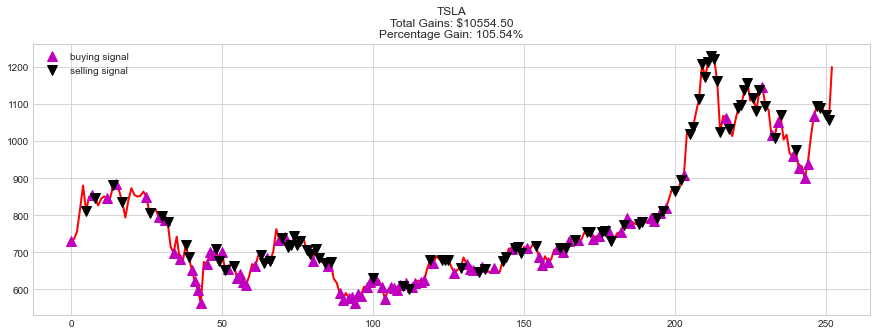


SPY
[*********************100%***********************]  1 of 1 completed
iter 10. reward: 2.242501
iter 20. reward: -1.743101
iter 30. reward: 3.443200
iter 40. reward: 4.509700
iter 50. reward: 3.955901
iter 60. reward: 5.608501
iter 70. reward: 6.673902
iter 80. reward: 6.747200
iter 90. reward: 7.272400
iter 100. reward: 10.151199
iter 110. reward: 8.615902
iter 120. reward: 8.984700
iter 130. reward: 8.877600
iter 140. reward: 7.787300
iter 150. reward: 10.747300
iter 160. reward: 11.024301
iter 170. reward: 12.316501
iter 180. reward: 11.463501
iter 190. reward: 13.110901
iter 200. reward: 14.321502
iter 210. reward: 11.267301
iter 220. reward: 13.392401
iter 230. reward: 10.967201
iter 240. reward: 13.511501
iter 250. reward: 14.496902
iter 260. reward: 15.744502
iter 270. reward: 16.345502
iter 280. reward: 17.645202
iter 290. reward: 17.507103
iter 300. reward: 16.625703
iter 310. reward: 20.110302
iter 320. reward: 16.905302
iter 330. reward: 17.833602
iter 340. reward: 18.60

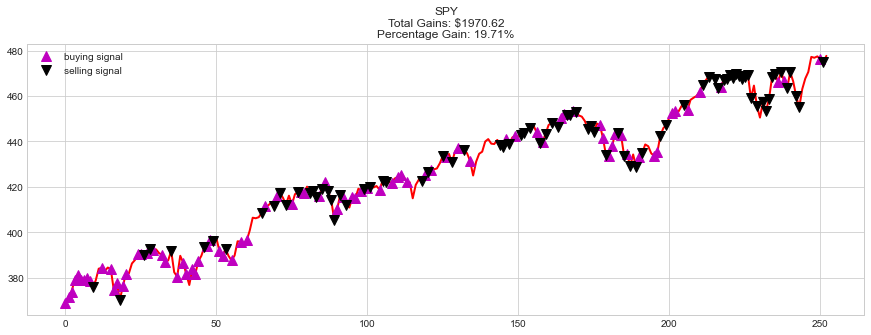


AAPL
[*********************100%***********************]  1 of 1 completed
iter 10. reward: 1.644500
iter 20. reward: 2.600000
iter 30. reward: 4.867200
iter 40. reward: 6.028800
iter 50. reward: 6.268400
iter 60. reward: 5.725901
iter 70. reward: 6.669501
iter 80. reward: 9.072201
iter 90. reward: 7.473401
iter 100. reward: 7.372401
iter 110. reward: 11.968401
iter 120. reward: 12.576101
iter 130. reward: 12.229401
iter 140. reward: 12.235201
iter 150. reward: 11.963701
iter 160. reward: 9.042901
iter 170. reward: 11.801200
iter 180. reward: 11.421501
iter 190. reward: 9.878301
iter 200. reward: 12.015601
iter 210. reward: 11.808501
iter 220. reward: 12.338101
iter 230. reward: 9.704001
iter 240. reward: 10.473701
iter 250. reward: 10.689001
iter 260. reward: 12.160601
iter 270. reward: 12.988401
iter 280. reward: 10.062601
iter 290. reward: 13.116301
iter 300. reward: 11.743501
iter 310. reward: 11.126701
iter 320. reward: 12.771501
iter 330. reward: 13.117301
iter 340. reward: 14.04

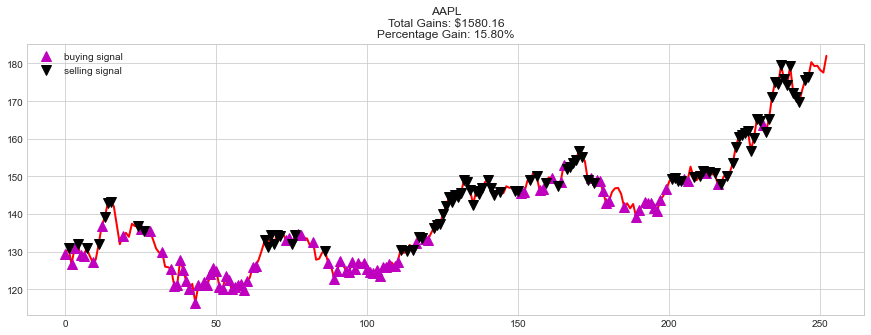

In [29]:
for ticker_name in ticker_list:
    print(f'\n{ticker_name}')
    %run modelling/agent_es.ipynb
    globals()[f'es_ROI_{ticker_name}'] = round(invest, 2)

## Results <a id = 5> </a> 
[Back to Top](#0)

In [30]:
algo_list = ['base_ROI_', 'bb_ROI_', 'macd_ROI_', 'lstm_ROI_', 'es_ROI_']
gen_list = []

for a in algo_list:
    for t in ticker_list:
        gen_list.append(a+t)

models_list = ['Base Model', 'Bollinger Bands', 'MACD', 'LSTM', 'Evolution Strategy']

def average(y):
    return str(round(sum([float(x.split(' ')[0]) for x in y])/len(y),1))+' %'

base = [f'{eval(x):.1f} %' for x in gen_list if algo_list[0] in x]
base_ave = average(base)

bb = [f'{eval(x):.1f} %' for x in gen_list if algo_list[1] in x]
bb_ave = average(bb)

macd = [f'{eval(x):.1f} %' for x in gen_list if algo_list[2] in x]
macd_ave = average(macd)

lstm = [f'{eval(x):.1f} %' for x in gen_list if algo_list[3] in x]
lstm_ave = average(lstm)

es = [f'{eval(x):.1f} %' for x in gen_list if algo_list[4] in x]
es_ave = average(es)

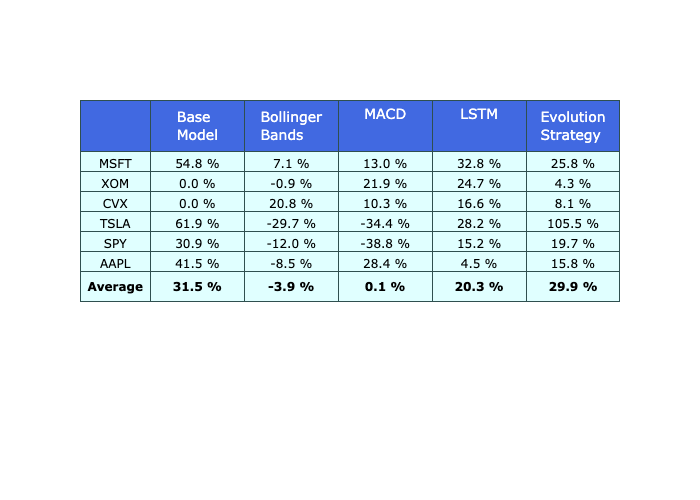

In [31]:
fig = go.Figure(data=[go.Table(
    columnwidth = [300, 400],
    header=dict(values=['']+models_list,
                line_color='darkslategray',
                fill_color='royalblue',
                align='center',
                font=dict(color='white', size=14)
               ),
    cells=dict(values=[
                 ticker_list+['<b>Average</b>'],
                 base+['<b>'+base_ave+'</b>'], 
                 bb+['<b>'+bb_ave+'</b>'],
                 macd+['<b>'+macd_ave+'</b>'],
                 lstm+['<b>'+lstm_ave+'</b>'],
                 es+['<b>'+es_ave+'</b>']
                 ],
               line_color='darkslategray',
               fill_color='lightcyan',
               align='center',
               font=dict(color='black', size=12)
              )
)])
fig.show()
fig.write_image("images/result_table.png")
Image('images/result_table.png')

## Conclusion <a id = 6> </a> 
[Back to Top](#0)

- **Base model (buy and hold strategy)** on average performed the best with **average ROI of 31.5%**
- Technical indicators Bollinger Bands and MACD did very poorly
- Machine learning models fared better compared to technical indicators
- The stock market is a very volatile and complex system
- Historical data is not enough to explain its behavior


## Future Work <a id = 7> </a> 
[Back to Top](#0)

To improve our predictions, the below could be performed for future considerations:
- Continue refining the hyperparameters of current models
- Utilize other models such as ADX (Average Directional Movement Index) and other DRL models
- Fundamental analysis
- Sentiment analysis (twitter, news, social media etc.)
- Local/global economy analysis

## References <a id = 8> </a> 
[Back to Top](#0)

- Turin, A. (2020, March 8). Machine Learning for day trading. Medium. Retrieved March 2, 2022, from towardsdatascience.com/machine-learning-for-day-trading-27c08274df54.

- Jansen, Stefan. “Machine Learning for Algorithmic Trading.” GitHub, PacktPublishing, github.com/PacktPublishing/Machine-Learning-for-Algorithmic-Trading-Second-Edition.

- T.M. “Quant-Trading.” GitHub, 1 Mar. 2022, github.com/je-suis-tm/quant-trading. Accessed 2 Mar. 2022.

- Dector, Aldo. “Moving-Average-Trading-Strategy-With-Python.” GitHub, 25 Nov. 2021, github.com/aldodec/Moving-Average-Trading-Strategy-with-Python. Accessed 2 Mar. 2022.

- Zhang, Leon. “Algorithmic Stock Trading.” GitHub, 30 Jan. 2022, github.com/leonz12345/Algorithmic_Stock_Trading. Accessed 2 Mar. 2022.

- ZOLKEPLI, HUSEIN. “Huseinzol05/Stock-Prediction-Models.” GitHub, 1 Mar. 2022, github.com/huseinzol05/Stock-Prediction-Models. Accessed 2 Mar. 2022.

- Orac, Roman. “Buy and Hold Trading Strategy.” Medium, 13 Dec. 2020, towardsdatascience.com/buy-and-hold-trading-strategy-66b4c3ac9b68. Accessed 2 Mar. 2022.